In [1]:
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "02_ml_models/02b_neural_network.ipynb"
_nb_title = "Flowers Image Classification using a neural network"

_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/takumiohym/practical-ml-vision-book-ja/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/>""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3]))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?name=Flowers+Image+Classification+using+a+neural+network&download_url=https%3A%2F%2Fgithub.com%2Ftakumiohym%2Fpractical-ml-vision-book-ja%2Fraw%2Fmaster%2F02_ml_models%2F02b_neural_network.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/02_ml_models/02b_neural_network.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/02_ml_models/02b_neural_network.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/02_ml_models/02b_neural_network.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/>

# ニューラルネットワークを使用した花の画像分類  

このノートブックでは、tf-flowersデータセットを分類するためのニューラルネットワークを構築する方法を示します。  

データ探索の多くは、コンパニオンノートブック02a_machine_perception.ipynbで行われました。  


## GPUを有効にする  

このノートブックは、GPUが接続された環境での実行を推奨しています。

Vertex AI WorkbenchやColabでGPUを使用する方法については[実行環境のセットアップ
](https://github.com/takumiohym/practical-ml-vision-book-ja/tree/main/environment_setup)を参照してください。

In [2]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.8.2
Found GPU at: /device:GPU:0


2022-12-19 16:12:48.856775: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 16:12:49.499473: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 16:12:49.511111: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 16:12:49.511858: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [3]:
# Helper functions
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric]);
        ax[idx].legend([metric, 'val_' + metric])

# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(filename):
    f, ax = plt.subplots(3, 5, figsize=(25,15))
    dataset = (tf.data.TextLineDataset(filename).map(decode_csv))
    for idx, (img, label) in enumerate(dataset.take(15)):
        ax[idx//5, idx%5].imshow((img.numpy()));
        batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
        batch_pred = model.predict(batch_image)
        pred = batch_pred[0]
        label = CLASS_NAMES[label.numpy()]
        pred_label_index = tf.math.argmax(pred).numpy()
        pred_label = CLASS_NAMES[pred_label_index]
        prob = pred[pred_label_index]
        ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

def show_trained_weights(model):
    # CLASS_NAMES: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
    LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
    WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

    f, ax = plt.subplots(1, 5, figsize=(15,15))
    for flower in range(len(CLASS_NAMES)):
        weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
        min_wt = tf.math.reduce_min(weights).numpy()
        max_wt = tf.math.reduce_max(weights).numpy()
        flower_name = CLASS_NAMES[flower]
        print("Scaling weights for {} in {} to {}".format(
            flower_name, min_wt, max_wt))
        weights = (weights - min_wt)/(max_wt - min_wt)
        ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
        ax[flower].set_title(flower_name);

In [4]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
    # Read the file
    img = tf.io.read_file(filename)
    # 圧縮された文字列を3次元のuint8のテンソルに変換する
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize the image to the desired size.
    return tf.image.resize(img, reshape_dims)

CLASS_NAMES = [item.numpy().decode("utf-8") for item in 
               tf.strings.regex_replace(
                 tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/*"),
                 "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", "")]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

# the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
    record_defaults = ["path", "flower"]
    filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
    return img, label

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


2022-12-19 16:12:50.405107: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 16:12:50.405858: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 16:12:50.406452: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 16:12:50.407435: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 16:12:50.408058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

## ニューラルネットワーク(NN)モデル  

隠れ層に非線形レイヤーを1つ追加します

In [5]:
BATCH_SIZE = 32

train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv).cache()).batch(BATCH_SIZE)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv).cache()).batch(BATCH_SIZE)

# NN with one hidden layer
model = tf.keras.Sequential([
          tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
          tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
          tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

Epoch 1/10
104/104 [==============================] - 78s 736ms/step - loss: 10.5988 - accuracy: 0.3091 - val_loss: 3.2753 - val_accuracy: 0.3270
Epoch 2/10
104/104 [==============================] - 1s 13ms/step - loss: 3.1518 - accuracy: 0.3964 - val_loss: 2.3731 - val_accuracy: 0.3486
Epoch 3/10
104/104 [==============================] - 1s 12ms/step - loss: 1.8689 - accuracy: 0.4815 - val_loss: 2.4125 - val_accuracy: 0.4081
Epoch 4/10
104/104 [==============================] - 1s 12ms/step - loss: 2.2093 - accuracy: 0.4391 - val_loss: 1.6520 - val_accuracy: 0.2946
Epoch 5/10
104/104 [==============================] - 1s 12ms/step - loss: 1.4291 - accuracy: 0.3703 - val_loss: 1.5620 - val_accuracy: 0.2378
Epoch 6/10
104/104 [==============================] - 1s 12ms/step - loss: 1.3664 - accuracy: 0.3791 - val_loss: 1.4060 - val_accuracy: 0.4378
Epoch 7/10
104/104 [==============================] - 1s 12ms/step - loss: 1.2916 - accuracy: 0.4300 - val_loss: 1.6057 - val_accuracy: 0.3

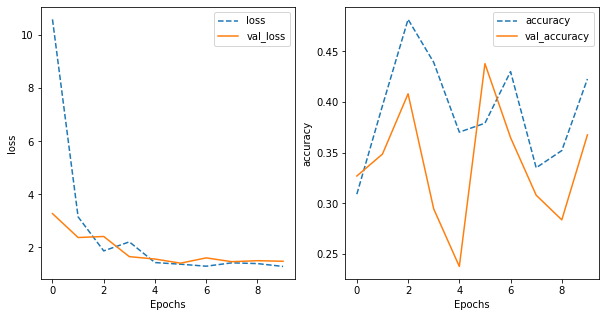

In [6]:
training_plot(['loss', 'accuracy'], history)

In [7]:
# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001, # default in Adam constructor
                       l1 = 0,
                       l2 = 0,
                       num_hidden = 128):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)

    train_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
      map(decode_csv).cache()).batch(batch_size)

    eval_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
      map(decode_csv).cache()).batch(batch_size)

  # NN with one hidden layers
    model = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              tf.keras.layers.Dense(num_hidden,
                                    kernel_regularizer=regularizer, 
                                    activation=tf.keras.activations.relu),
              tf.keras.layers.Dense(len(CLASS_NAMES), 
                                    kernel_regularizer=regularizer,
                                    activation='softmax')
  ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
    training_plot(['loss', 'accuracy'], history)
    return model

Epoch 1/10
104/104 [==============================] - 69s 662ms/step - loss: 2.2791 - accuracy: 0.3527 - val_loss: 2.2999 - val_accuracy: 0.3162
Epoch 2/10
104/104 [==============================] - 1s 12ms/step - loss: 1.6331 - accuracy: 0.4170 - val_loss: 2.0922 - val_accuracy: 0.3514
Epoch 3/10
104/104 [==============================] - 1s 12ms/step - loss: 1.4380 - accuracy: 0.4597 - val_loss: 1.5732 - val_accuracy: 0.3811
Epoch 4/10
104/104 [==============================] - 1s 12ms/step - loss: 1.2787 - accuracy: 0.4967 - val_loss: 1.5973 - val_accuracy: 0.3919
Epoch 5/10
104/104 [==============================] - 1s 12ms/step - loss: 1.2534 - accuracy: 0.5224 - val_loss: 1.6258 - val_accuracy: 0.3649
Epoch 6/10
104/104 [==============================] - 1s 12ms/step - loss: 1.2213 - accuracy: 0.5364 - val_loss: 1.6093 - val_accuracy: 0.4000
Epoch 7/10
104/104 [==============================] - 1s 12ms/step - loss: 1.1304 - accuracy: 0.5667 - val_loss: 1.5174 - val_accuracy: 0.42

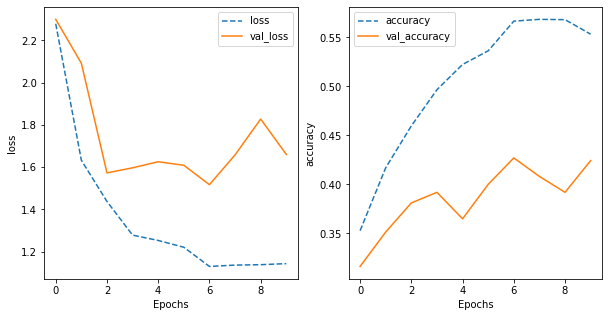

In [8]:
# Smaller Learning Late
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=128)

Epoch 1/10
104/104 [==============================] - 68s 646ms/step - loss: 2.3680 - accuracy: 0.3555 - val_loss: 1.4680 - val_accuracy: 0.4000
Epoch 2/10
104/104 [==============================] - 2s 16ms/step - loss: 1.5830 - accuracy: 0.4203 - val_loss: 1.7128 - val_accuracy: 0.4432
Epoch 3/10
104/104 [==============================] - 2s 16ms/step - loss: 1.4335 - accuracy: 0.4642 - val_loss: 1.6978 - val_accuracy: 0.4784
Epoch 4/10
104/104 [==============================] - 2s 16ms/step - loss: 1.3023 - accuracy: 0.5127 - val_loss: 1.5951 - val_accuracy: 0.4405
Epoch 5/10
104/104 [==============================] - 2s 16ms/step - loss: 1.2573 - accuracy: 0.5318 - val_loss: 1.6623 - val_accuracy: 0.4838
Epoch 6/10
104/104 [==============================] - 2s 16ms/step - loss: 1.2129 - accuracy: 0.5367 - val_loss: 1.5416 - val_accuracy: 0.4324
Epoch 7/10
104/104 [==============================] - 2s 16ms/step - loss: 1.1808 - accuracy: 0.5670 - val_loss: 1.9134 - val_accuracy: 0.41

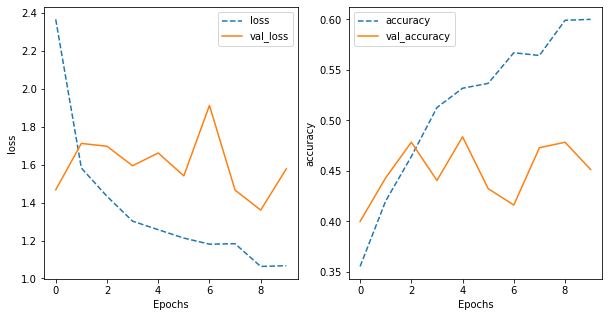

In [9]:
# Lager `num_hidden`
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=256)

Epoch 1/10
104/104 [==============================] - 69s 659ms/step - loss: 2.4784 - accuracy: 0.3576 - val_loss: 1.5285 - val_accuracy: 0.4649
Epoch 2/10
104/104 [==============================] - 1s 14ms/step - loss: 1.5378 - accuracy: 0.4482 - val_loss: 1.6692 - val_accuracy: 0.4676
Epoch 3/10
104/104 [==============================] - 1s 14ms/step - loss: 1.4626 - accuracy: 0.4812 - val_loss: 1.6800 - val_accuracy: 0.4541
Epoch 4/10
104/104 [==============================] - 1s 14ms/step - loss: 1.3864 - accuracy: 0.5218 - val_loss: 1.6133 - val_accuracy: 0.4378
Epoch 5/10
104/104 [==============================] - 1s 14ms/step - loss: 1.3136 - accuracy: 0.5506 - val_loss: 1.5728 - val_accuracy: 0.4459
Epoch 6/10
104/104 [==============================] - 2s 14ms/step - loss: 1.2598 - accuracy: 0.5682 - val_loss: 1.4973 - val_accuracy: 0.4541
Epoch 7/10
104/104 [==============================] - 1s 14ms/step - loss: 1.2136 - accuracy: 0.5858 - val_loss: 1.5313 - val_accuracy: 0.46

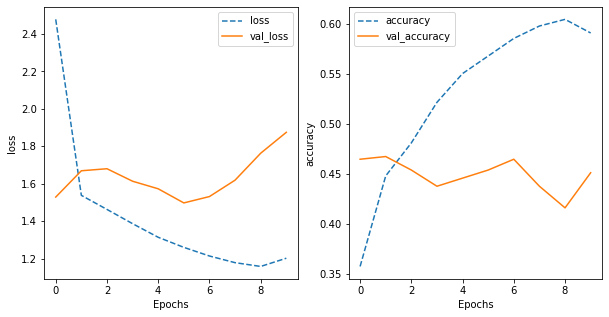

In [10]:
# Add L2 Regularization
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0.001, num_hidden=128)

## ハイパーパラメータの調整

In [11]:
!pip install keras-tuner  --user

In [14]:
import keras_tuner as kt

def build_model(hp):
    lrate = hp.Float('lrate', 1e-4, 1e-1, sampling='log')
    l1 = 0
    l2 = hp.Choice('l2', values=[0.0, 1e-1, 1e-2, 1e-3, 1e-4])
    num_hidden = hp.Int('num_hidden', 32, 256, 32)

    regularizer = tf.keras.regularizers.l1_l2(l1, l2)

    # NN with one hidden layers
    model = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              tf.keras.layers.Dense(num_hidden,
                                    kernel_regularizer=regularizer, 
                                    activation=tf.keras.activations.relu),
              tf.keras.layers.Dense(len(CLASS_NAMES), 
                                    kernel_regularizer=regularizer,
                                    activation='softmax')
  ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

batch_size = 32
train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv).cache()).batch(batch_size)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv).cache()).batch(batch_size) 

tuner = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective('val_accuracy', 'max'), 
    max_trials=10,
    num_initial_points=2, 
    overwrite=False) # True to start afresh.

tuner.search(
    train_dataset, validation_data=eval_dataset,
    epochs=5,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)]
)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [15]:
topN = 1
for x in range(topN):
    print(tuner.get_best_hyperparameters(topN)[x].values)
    print(tuner.get_best_models(topN)[x].summary())
  

{'lrate': 0.0001, 'l2': 0.0001, 'num_hidden': 160}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 160)               24084640  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 805       
Total params: 24,085,445
Trainable params: 24,085,445
Non-trainable params: 0
_________________________________________________________________
None


ハイパーパラメータの最適な組み合わせ: （実行の度に異なります）
* l2 = 0.0001、lrate = 0.0001、num_hidden = 64
* score= 0.4595

## ディープニューラルネットワーク  

DNNをトレーニングしましょう。  
隠れ層数と各層のノードの数をパラメーター化します

In [16]:
def train_and_evaluate(batch_size = 32,
                       lrate = 0.0001,
                       l1 = 0,
                       l2 = 0.001,
                       num_hidden = [64, 16]):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)

    train_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
      map(decode_csv).cache()).batch(batch_size)

    eval_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
      map(decode_csv).cache()).batch(32) # this doesn't matter

    # NN with one hidden layers
    layers = [tf.keras.layers.Flatten(
      input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
      name='input_pixels')]
    layers = layers + [
      tf.keras.layers.Dense(nodes,
                            kernel_regularizer=regularizer, 
                            activation=tf.keras.activations.relu,
                            name='hidden_dense_{}'.format(hno))
          for hno, nodes in enumerate(num_hidden)
    ]
    layers = layers + [
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
    ]

    model = tf.keras.Sequential(layers, name='flower_classification')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
    print(model.summary())
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
    training_plot(['loss', 'accuracy'], history)
    return model

Model: "flower_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_pixels (Flatten)       (None, 150528)            0         
_________________________________________________________________
hidden_dense_0 (Dense)       (None, 64)                9633856   
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 16)                1040      
_________________________________________________________________
flower_prob (Dense)          (None, 5)                 85        
Total params: 9,634,981
Trainable params: 9,634,981
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
104/104 [==============================] - 64s 607ms/step - loss: 1.8753 - accuracy: 0.3242 - val_loss: 1.5398 - val_accuracy: 0.3649
Epoch 2/10
104/104 [==============================] - 1s 11ms/step - loss: 1.6193 -

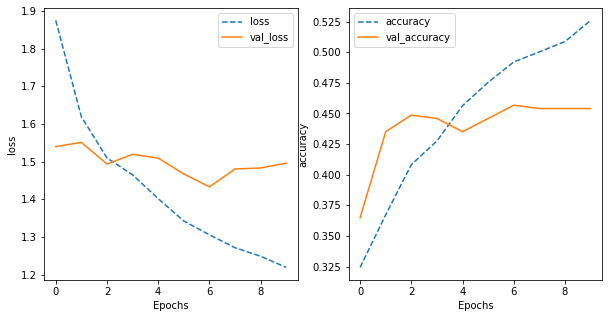

In [17]:
model = train_and_evaluate(lrate=0.0001, l2=0.001, num_hidden = [64, 16])

### ドロップアウトとバッチ正規化
各隠れ層の後にドロップアウトレイヤーとバッチ正規化レイヤーを追加します。  


In [19]:
def train_and_evaluate(batch_size = 32,
                       lrate = 0.0001,
                       l1 = 0,
                       l2 = 0.001,
                       dropout_prob = 0.4,
                       num_hidden = [64, 16]):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)

    train_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
      map(decode_csv).cache()).batch(batch_size)

    eval_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
      map(decode_csv).cache()).batch(32) # this doesn't matter

    # NN with one hidden layers
    layers = [tf.keras.layers.Flatten(
      input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
      name='input_pixels')]
    for hno, nodes in enumerate(num_hidden):
        layers.extend([
            tf.keras.layers.Dense(nodes,
                                kernel_regularizer=regularizer, 
                                name='hidden_dense_{}'.format(hno)),
            tf.keras.layers.BatchNormalization(scale=False, # ReLU
                                             center=False, # have bias in Dense
                                             name='batchnorm_dense_{}'.format(hno)),
            #move activation to come after batchnorm
            tf.keras.layers.Activation('relu', name='relu_dense_{}'.format(hno)),
            tf.keras.layers.Dropout(rate=dropout_prob,
                                 name='dropout_dense_{}'.format(hno)),                         
        ])

    layers.append(
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
    )

    model = tf.keras.Sequential(layers, name='flower_classification')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
    print(model.summary())
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
    training_plot(['loss', 'accuracy'], history)
    return model

Model: "flower_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_pixels (Flatten)       (None, 150528)            0         
_________________________________________________________________
hidden_dense_0 (Dense)       (None, 64)                9633856   
_________________________________________________________________
batchnorm_dense_0 (BatchNorm (None, 64)                128       
_________________________________________________________________
relu_dense_0 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_dense_0 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 16)                1040      
_________________________________________________________________
batchnorm_dense_1 (BatchNorm (None, 16)      

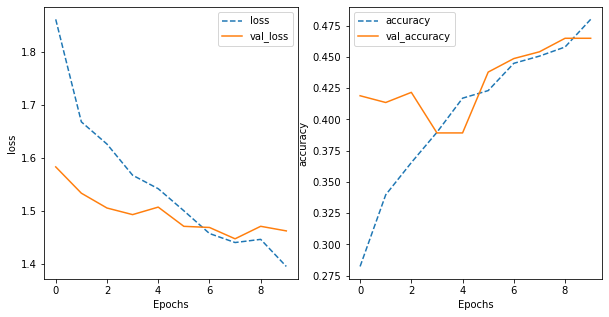

In [20]:
model = train_and_evaluate(dropout_prob=0.4)

## ダイアグラム  

これらでは本書の中で使用された図をプロットします。

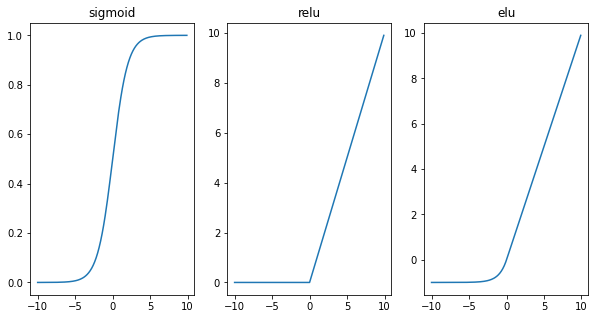

In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt

fig, ax = plt.subplots(1, 3, figsize=(10,5))
x = np.arange(-10.0, 10.0, 0.1)
y = tf.keras.activations.sigmoid(x)
ax[0].plot(x, y);
ax[0].set_title("sigmoid")
y = tf.keras.activations.relu(x)
ax[1].plot(x, y);
ax[1].set_title("relu")
y = tf.keras.activations.elu(x)
ax[2].plot(x, y);
ax[2].set_title("elu");

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               19267712  
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 19,268,357
Trainable params: 19,268,357
Non-trainable params: 0
_________________________________________________________________


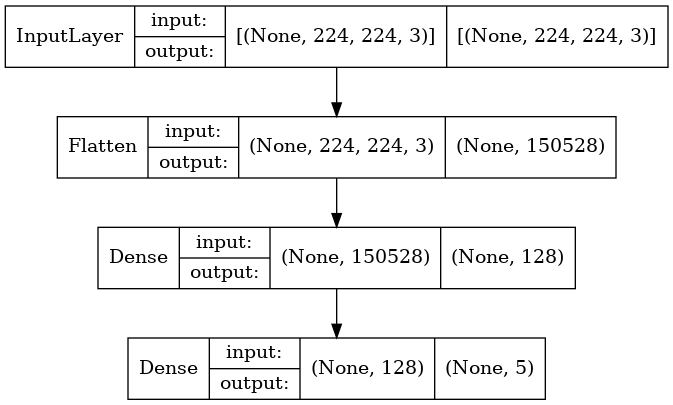

In [22]:
model = tf.keras.Sequential([
   tf.keras.layers.Flatten(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
   tf.keras.layers.Dense(128, activation='relu'),
   tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [23]:
model = tf.keras.Sequential([
   tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
   tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 752645    
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
_________________________________________________________________


## License
Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.